In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time

## Procedure
1. Parameters : α(핫스팟의 기준) / β(도시기준인구)
2. 각 연도마다 ( 각 도시 마다 : 찾아서 ρ가지고 k구하기 )
3. 결과 : (1plot = 1city) (x=$\tilde{k}$), y=log($\tilde{P}$) ⇒ $P*$ 걱정없이 β분석 가능

In [2]:
gaz_zcta_years = [2000, 2010, 2012, 2013, 2014, 2015, 2016]
gaz_zcta = []
for y in gaz_zcta_years:
    fname = 'gaz_zcta' + str(y) + '.csv'
    gaz = pd.read_csv(fname, sep=',', header=(0), dtype={'GEOID':str, 'ALAND':float})
    gaz_zcta.append(gaz)

print(len(gaz_zcta), '개 로드 완료!')

def which_gaz(year):
    test = [abs(year-zear) for zear in gaz_zcta_years]
    return gaz_zcta[test.index(min(test))]

7 개 로드 완료!


In [3]:
class Year_read:
    def __init__(self, prefix, year):
        self.year = year
        self.gaz = which_gaz(year)

        fname = prefix + str(year) + '.csv'
        self.zbp = pd.read_csv(fname, header=(0), dtype={'EMP':int, 'ZIP':str, 'rho':float})
    
    def citify2(cities):
        out = []
        for city in cities:
            df = self.zbp[self.zbp['GEO_TTL'] == city]
            self.city.append(df)
        return out

In [5]:
years = np.array(gaz_zcta_years)
dat = []
for y in years:
    dat.append(Year_read('dat', y))

tflag = time()
for i,d in enumerate(dat):
    for row in d.zbp.iloc:
        idx = row.index_gaz
        if not np.isnan(idx):
            idx = int(idx)
            pop = d.gaz.iloc[idx].POP
            d.zbp.loc[row.name, 'POP'] = pop
    print(i+1, '/', len(dat), '(', d.year, ')', time()-tflag, 'sec'); tflag = time()

1 / 7 ( 2000 ) 10.701197624206543 sec
2 / 7 ( 2010 ) 11.630974769592285 sec
3 / 7 ( 2012 ) 11.836487531661987 sec
4 / 7 ( 2013 ) 11.866453409194946 sec
5 / 7 ( 2014 ) 12.188073873519897 sec
6 / 7 ( 2015 ) 12.250781297683716 sec
7 / 7 ( 2016 ) 13.18333101272583 sec


In [18]:
ykp = []
alpha = 5
beta = 100
count_k = lambda v: len([w for w in v if w > max(v)/alpha])

for d in dat:
    tflag = time()
    g = d.zbp.dropna().groupby(['GEO_TTL'])
    r_count = g['rho'].apply(count_k)
    r_max = g['rho'].max()
    g_idx = g.groups

    new_block = []
    ykp.append(pd.DataFrame(columns=['Y','GEO_TTL', 'k', 'P']))
    for geo, p in zip(g_idx, g['POP'].sum()):
        if p >= beta and r_max[geo] > 0:
            k = 1
            k_test = len(g_idx[geo])
            if k_test > 1:
                k = r_count[geo]
            new_row = {'Y':d.year, 'GEO_TTL':geo, 'k':k, 'P':p}
            ykp[-1] = ykp[-1].append(new_row, ignore_index=True)
    print(d.year, '/', time()-tflag, 'sec')

ykp = pd.concat(tuple(ykp), ignore_index=True)
ykp.head(3)

2000 / 56.77648949623108 sec
2010 / 52.30805444717407 sec
2012 / 46.25149464607239 sec
2013 / 45.980295181274414 sec
2014 / 46.433661222457886 sec
2015 / 68.98304176330566 sec
2016 / 65.6169319152832 sec


,Y,GEO_TTL,k,P
0,2000,"Aaronsburg, PA",1,1091.0
1,2000,"Abbeville, AL",1,6991.0
2,2000,"Abbeville, GA",1,3870.0


In [315]:
ykp_sort = ykp.sort_values(by='GEO_TTL')

count = lambda v: len(v)
geo_len = ykp.groupby(['GEO_TTL'])['k'].apply(count).to_dict()


tflag = time(); N = len(geo_len)
tdiv = 10; tarr = [round(T*N/tdiv) for T in range(1,tdiv+1)]

coords = []
for i, geo in enumerate(geo_len):
    if geo_len[geo] > 1:
        df = ykp_sort[ykp_sort['GEO_TTL']==geo]
        k_mod = df['k'] / df['k'].min()
        P_mod = df['P'] / df['k'].max()
#         df = pd.DataFrame([k_mod, P_mod]).T.sort_values(by='k',ignore_index=True)
        coords.append([k_mod.to_numpy(), P_mod.to_numpy()])
        hook.append([k_mod, P_mod])
    if i == tarr[0]:
        print(i, '/', N, '...', time()-tflag, 'sec')
        tarr.pop(0); tflag=time() 

2616 / 26164 ... 31.55303406715393 sec
5233 / 26164 ... 31.079041481018066 sec
7849 / 26164 ... 31.541630744934082 sec
10466 / 26164 ... 31.575798273086548 sec
13082 / 26164 ... 31.233326196670532 sec
15698 / 26164 ... 33.551202058792114 sec
18315 / 26164 ... 32.708110094070435 sec
20931 / 26164 ... 31.370471239089966 sec
23548 / 26164 ... 30.544503688812256 sec


<ipython-input-313-643a0d9b4e00>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(range(10),minor=True)


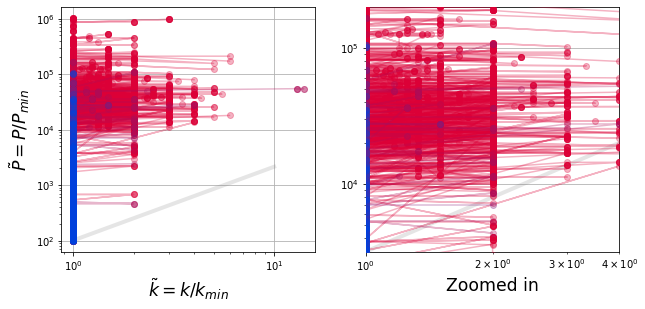

In [313]:
fig, (ax,cx) = plt.subplots(1,2,figsize=(10,4.5))
fignum = fig.number
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$\\tilde{k}=k/k_{min}$', fontsize='xx-large')
ax.set_ylabel('$\\tilde{P}=P/P_{min}$', fontsize='xx-large')
ax.set_xticklabels(range(10),minor=True)
ax.grid()

cx.set_xscale('log'); cx.set_yscale('log')
cx.set_xlabel('Zoomed in', fontsize='xx-large')
cx.set_xlim(1,4); cx.set_ylim(10**3.5, 10**5.3)
cx.grid()

blue = np.array([0, 0.263, 0.874])
red = np.array([0.863, 0, 0.215])
cvec = red - blue
palette = [tuple(blue + t*cvec) for t in np.linspace(0,1,6)]

hook = None
N = []
theta = [[],[],[],[],[],[]]
for x, y in coords:
    n = len(x); N.append(n)
    theta_temp = []
    for i in range(n-1):
        hook = [i, n-1, x, y]
        dx, dy = x[i+1]-x[i], y[i+1]-y[i]
        t = np.angle(dx + dy*1j)
#         if t < 1.5: theta_temp.append(t)
        theta_temp.append(t)
#     if len(theta_temp) > 0: theta[n-2].append(np.mean(theta_temp))
    theta[n-2].append(np.mean(theta_temp))
    
    ax.plot(x, y, '-o', alpha=0.3, color=palette[n-2], zorder=10-n)
    cx.plot(x, y, '-o', alpha=0.3, color=palette[n-2], zorder=10-n)
    
u = np.linspace(1,10,100)
v = np.power(u,1.33)
ax.plot(u, 100*v, color='gray', alpha=0.2, lw=4)
cx.plot(u, (10**3.5)*v, color='gray', alpha=0.2, lw=4)

plt.show()

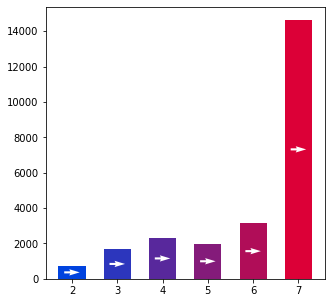

In [314]:
fig, bx = plt.subplots(figsize=(5,5))

height, bins, patches = bx.hist(N, bins=range(2,9),
                                rwidth=0.6, align='left')
for leftedge, thispatch in zip(bins, patches):
    thispatch.set_facecolor(palette[int(leftedge)-2])

Z = np.zeros(6)
for i,arr in enumerate(theta):
    Z[i] = np.mean(arr)
U,V = np.cos(Z), np.sin(Z)
bx.quiver(bins[:-1], height/2, U, V, angles='xy', color='w', pivot='mid', zorder=2)


plt.show()